#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

In [2]:
from numpy.linalg import eig, svd
from sklearn.decomposition import PCA

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

#### Test for CUDA

In [4]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Data loader, train and test sets

In [5]:
batch_size = 200

In [6]:
# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Classes in the MNIST dataset
classes = [str(x) for x in range(10)]
num_classes = len(classes)
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [8]:
# Print some information about the datasets
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))
print("Number of classes:", num_classes)

Number of training examples: 60000
Number of test examples: 10000
Number of classes: 10


#### Model and other hyper-params

In [9]:
# Hyperparameters
input_size = 28  # MNIST image size (28x28)
num_steps = 28
hidden_size = 128
num_layers = 1
num_epochs = 50
learning_rate = 0.001

In [10]:
N = hidden_size ## num. of neurons in RNN

In [11]:
def initialize_weights(N, index_ranges, signs):
    weights = np.zeros((N, N))
    for ii, (start, end) in enumerate(index_ranges):
        limit = 1 / np.sqrt(N) if signs[ii] == 1 else -1/np.sqrt(N)
        weights[:, start:end] = np.random.uniform(0, limit, size=(N, end-start))
    return weights

In [12]:
def generate_mask(weights, index_ranges, signs):
    mask = np.zeros_like(weights)
    for i, (start, end) in enumerate(index_ranges):
        if signs[i] == 1:
            mask[:, start:end] = np.where(weights[:, start:end] > 0, 1, 0)
        elif signs[i] == -1:
            mask[:, start:end] = np.where(weights[:, start:end] < 0, 1, 0)
    return mask

In [13]:
# Define the neural network
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, device):
        
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, num_classes)
        self.n_classes = num_classes
        self.device = device

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, nSteps, inDim = x.shape
        
        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)
        pred = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        
        for ii in range(nSteps):
            ip = torch.unsqueeze(x[:,ii,:],1)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
            fr_mask = ht.clone()>0
            htt = fr_mask*ht.clone() ## mask firing rate
            h0 = htt ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred[:,ii,:] = self.fc(ops[:, ii, :].clone())
            
        out = pred[:, -1, :].clone()  #Take the output from the last time step
        
        return out, htt

#### Connectivity and sign constraints

In [14]:
nRuns = 5

In [15]:
frac_ex = 0.8
frac_in = 1-frac_ex

In [16]:
signs = [1,-1]
index_ranges = [(0,int(N*frac_ex)),(int(N*frac_ex),N)]

In [17]:
# Initialize the model
model = {}
weights_init = {}

In [18]:
for cntr in range(nRuns):
    model[cntr] = SimpleRNN(input_size, hidden_size, num_classes, device).to(device)
    weights_init[cntr] = initialize_weights(N,index_ranges,signs)
    model[cntr].rnn.weight_hh_l0.data = torch.from_numpy(weights_init[cntr]).float().to(device)

Text(0.5, 1.0, 'Initial Weights: Conventional RNN')

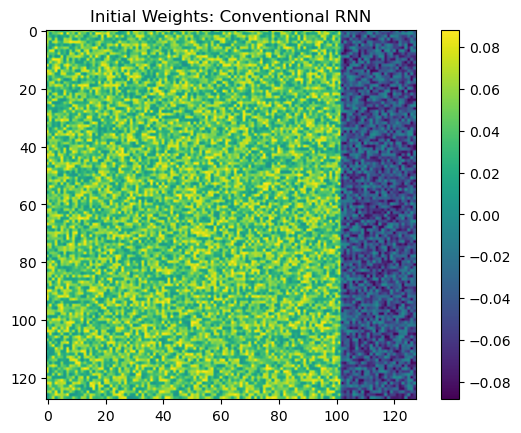

In [21]:
kk = 0

plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights: Dales Backprop')

In [36]:
# Save dictionary to a Numpy .npz file
np.savez('seq_mnist_weights_init_dales.npz', weights_init, pickle=True)

Text(0, 0.5, 'Counts')

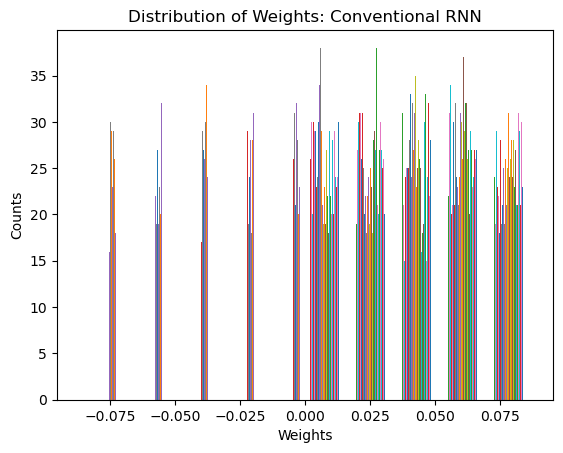

In [22]:
plt.hist(weights_init[kk])
plt.title('Distribution of Weights: Dales Backprop')
plt.xlabel('Weights')
plt.ylabel('Counts')

#### Model training

In [23]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = {}
for cntr in range(nRuns):
    optimizer[cntr] = optim.Adam(model[cntr].parameters(), lr=learning_rate)

In [24]:
train_losses = np.zeros((nRuns, num_epochs))
test_losses = np.zeros((nRuns, num_epochs))
accuracies = np.zeros((nRuns, num_epochs))

In [25]:
for run in tqdm(range(nRuns)):

    # Training the model
    for epoch in range(num_epochs):
        for ii, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28, 28).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, firing_rates = model[run](images)
            loss = criterion(outputs, labels)
            train_losses[run,epoch] = loss

            # Backward and optimize
            optimizer[run].zero_grad()
            loss.backward()
            optimizer[run].step()

             ## Dale's Backprop
            w = model[run].rnn.weight_hh_l0.detach().cpu().numpy()
            mask = generate_mask(w, index_ranges, signs)
            wm = w*mask
            model[run].rnn.weight_hh_l0.data = torch.from_numpy(wm).float().to(device)

            if (ii+1) % batch_size == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Test the model
        with torch.no_grad():
            correct = 0
            total = 0
            for images_test, labels_test in test_loader:
                images_test = images_test.reshape(-1, 28, 28).to(device)
                labels_test = labels_test.to(device)
                outputs_test, firing_rates_test = model[run](images_test)
                loss_test = criterion(outputs_test, labels_test)
                test_losses[run,epoch] = loss_test
                ## accuracy
                _, predicted = torch.max(outputs_test.data, 1)
                total += labels_test.size(0)
                correct += (predicted == labels_test).sum().item()

            print(f'Accuracy of the network on the test images: {100 * correct / total}%')
            accuracies[run,epoch] = 100 * correct / total

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\abalwani6\AppData\Local\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:509: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch [1/50], Loss: 2.3150
Accuracy of the network on the test images: 10.1%
Epoch [2/50], Loss: 1.5134
Accuracy of the network on the test images: 42.26%
Epoch [3/50], Loss: 1.2916
Accuracy of the network on the test images: 52.22%
Epoch [4/50], Loss: 1.1046
Accuracy of the network on the test images: 65.06%
Epoch [5/50], Loss: 0.8705
Accuracy of the network on the test images: 69.68%
Epoch [6/50], Loss: 0.8107
Accuracy of the network on the test images: 72.75%
Epoch [7/50], Loss: 0.8576
Accuracy of the network on the test images: 75.46%
Epoch [8/50], Loss: 0.8358
Accuracy of the network on the test images: 78.41%
Epoch [9/50], Loss: 0.5309
Accuracy of the network on the test images: 79.99%
Epoch [10/50], Loss: 0.5023
Accuracy of the network on the test images: 81.35%
Epoch [11/50], Loss: 0.5112
Accuracy of the network on the test images: 84.09%
Epoch [12/50], Loss: 0.4839
Accuracy of the network on the test images: 86.41%
Epoch [13/50], Loss: 0.4265
Accuracy of the network on the tes

 20%|██        | 1/5 [34:15<2:17:00, 2055.10s/it]

Accuracy of the network on the test images: 95.62%
Epoch [1/50], Loss: 2.2909
Accuracy of the network on the test images: 10.1%
Epoch [2/50], Loss: 1.8134
Accuracy of the network on the test images: 37.78%
Epoch [3/50], Loss: 1.5518
Accuracy of the network on the test images: 41.6%
Epoch [4/50], Loss: 1.4686
Accuracy of the network on the test images: 45.22%
Epoch [5/50], Loss: 1.1963
Accuracy of the network on the test images: 57.63%
Epoch [6/50], Loss: 0.9405
Accuracy of the network on the test images: 65.77%
Epoch [7/50], Loss: 0.8931
Accuracy of the network on the test images: 71.2%
Epoch [8/50], Loss: 0.8118
Accuracy of the network on the test images: 72.51%
Epoch [9/50], Loss: 0.7882
Accuracy of the network on the test images: 76.78%
Epoch [10/50], Loss: 0.7571
Accuracy of the network on the test images: 78.84%
Epoch [11/50], Loss: 0.6158
Accuracy of the network on the test images: 81.46%
Epoch [12/50], Loss: 0.4931
Accuracy of the network on the test images: 82.82%
Epoch [13/50]

 40%|████      | 2/5 [1:08:23<1:42:33, 2051.22s/it]

Accuracy of the network on the test images: 94.79%
Epoch [1/50], Loss: 2.3006
Accuracy of the network on the test images: 9.58%
Epoch [2/50], Loss: 1.8363
Accuracy of the network on the test images: 42.71%
Epoch [3/50], Loss: 1.1456
Accuracy of the network on the test images: 51.27%
Epoch [4/50], Loss: 1.1018
Accuracy of the network on the test images: 63.72%
Epoch [5/50], Loss: 0.9308
Accuracy of the network on the test images: 68.25%
Epoch [6/50], Loss: 0.7522
Accuracy of the network on the test images: 72.25%
Epoch [7/50], Loss: 0.7687
Accuracy of the network on the test images: 73.97%
Epoch [8/50], Loss: 0.6773
Accuracy of the network on the test images: 75.97%
Epoch [9/50], Loss: 0.6452
Accuracy of the network on the test images: 75.87%
Epoch [10/50], Loss: 0.5455
Accuracy of the network on the test images: 81.14%
Epoch [11/50], Loss: 0.5126
Accuracy of the network on the test images: 82.99%
Epoch [12/50], Loss: 0.4895
Accuracy of the network on the test images: 84.73%
Epoch [13/5

 60%|██████    | 3/5 [1:42:26<1:08:14, 2047.22s/it]

Accuracy of the network on the test images: 95.19%
Epoch [1/50], Loss: 2.3085
Accuracy of the network on the test images: 15.6%
Epoch [2/50], Loss: 1.6331
Accuracy of the network on the test images: 41.84%
Epoch [3/50], Loss: 1.4865
Accuracy of the network on the test images: 44.19%
Epoch [4/50], Loss: 1.3354
Accuracy of the network on the test images: 56.44%
Epoch [5/50], Loss: 1.0700
Accuracy of the network on the test images: 63.47%
Epoch [6/50], Loss: 1.0144
Accuracy of the network on the test images: 66.0%
Epoch [7/50], Loss: 0.8540
Accuracy of the network on the test images: 68.46%
Epoch [8/50], Loss: 0.8437
Accuracy of the network on the test images: 70.7%
Epoch [9/50], Loss: 0.7559
Accuracy of the network on the test images: 73.35%
Epoch [10/50], Loss: 0.6872
Accuracy of the network on the test images: 76.13%
Epoch [11/50], Loss: 0.6287
Accuracy of the network on the test images: 78.43%
Epoch [12/50], Loss: 0.6317
Accuracy of the network on the test images: 78.03%
Epoch [13/50]

 80%|████████  | 4/5 [2:16:27<34:04, 2044.96s/it]  

Accuracy of the network on the test images: 95.15%
Epoch [1/50], Loss: 2.3115
Accuracy of the network on the test images: 10.28%
Epoch [2/50], Loss: 1.8672
Accuracy of the network on the test images: 37.23%
Epoch [3/50], Loss: 1.3553
Accuracy of the network on the test images: 48.4%
Epoch [4/50], Loss: 1.3120
Accuracy of the network on the test images: 55.45%
Epoch [5/50], Loss: 0.9939
Accuracy of the network on the test images: 63.16%
Epoch [6/50], Loss: 0.9569
Accuracy of the network on the test images: 68.82%
Epoch [7/50], Loss: 0.9112
Accuracy of the network on the test images: 73.9%
Epoch [8/50], Loss: 0.5837
Accuracy of the network on the test images: 77.69%
Epoch [9/50], Loss: 0.5874
Accuracy of the network on the test images: 79.64%
Epoch [10/50], Loss: 0.5876
Accuracy of the network on the test images: 80.24%
Epoch [11/50], Loss: 0.6256
Accuracy of the network on the test images: 81.58%
Epoch [12/50], Loss: 0.4202
Accuracy of the network on the test images: 82.8%
Epoch [13/50]

100%|██████████| 5/5 [2:51:26<00:00, 2057.27s/it]

Accuracy of the network on the test images: 95.34%


In [26]:
weights_final = {}
for cntr in range(nRuns):
    weights_final[cntr] = model[cntr].rnn.weight_hh_l0.detach().cpu().numpy()

In [35]:
# Save dictionary to a Numpy .npz file
np.savez('seq_mnist_weights_final_dales.npz', weights_final, pickle=True)

Text(0.5, 1.0, 'Final Weights')

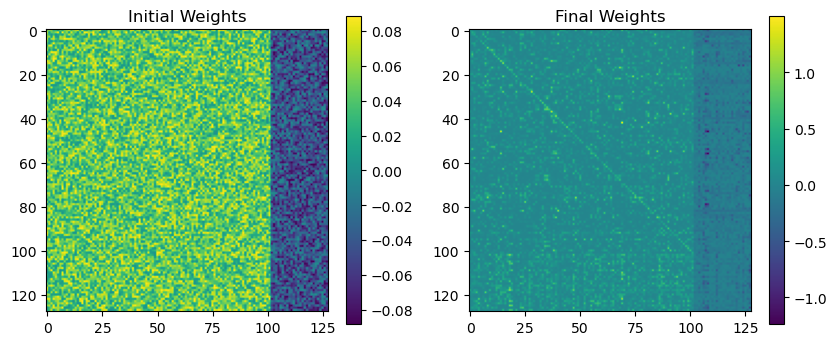

In [27]:
kk = 0

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights')

plt.subplot(122)
plt.imshow(weights_final[kk])
plt.colorbar()
plt.title('Final Weights')

Text(0, 0.5, 'Counts')

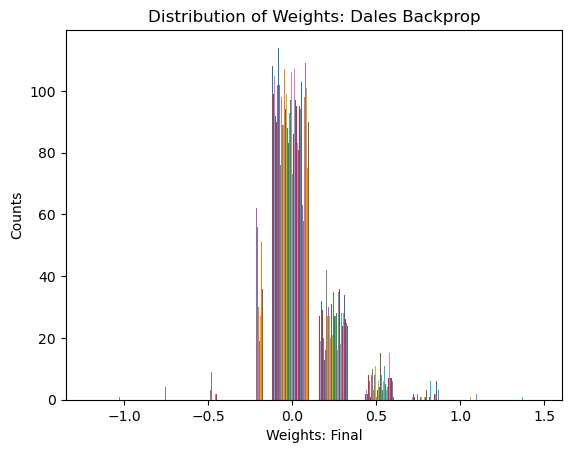

In [33]:
plt.hist(weights_final[kk])
plt.title('Distribution of Weights: Dales Backprop')
plt.xlabel('Weights: Final')
plt.ylabel('Counts')

In [34]:
## Save train, test losses + accuracies
np.save('seq_mnist_train_losses_dales_backprop',train_losses)
np.save('seq_mnist_test_losses_dales_backprop',test_losses)
np.save('seq_mnist_accuracies_dales_backprop',accuracies)

In [28]:
mean_train_losses = np.mean(train_losses, axis=0)
variance_train_losses = np.var(train_losses, axis=0)

mean_test_losses = np.mean(test_losses, axis=0)
variance_test_losses = np.var(test_losses, axis=0)

mean_accs = np.mean(accuracies, axis=0)
variance_accs = np.var(accuracies, axis=0)

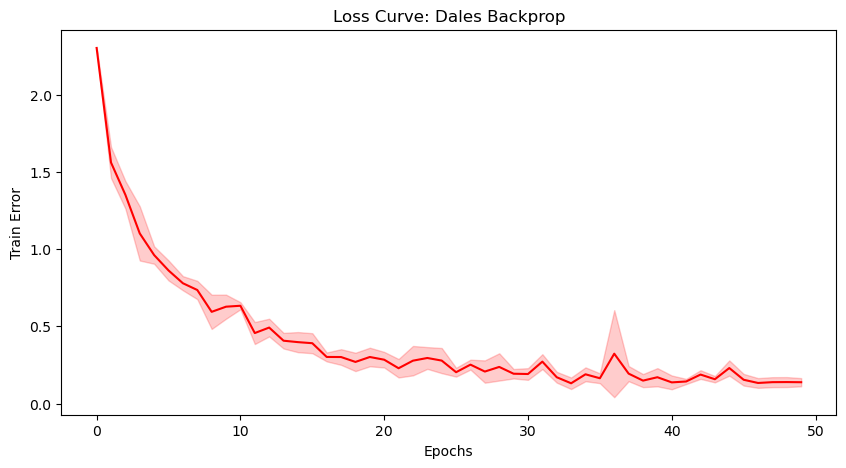

In [32]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=mean_train_losses, color='r')
plt.fill_between(x, mean_train_losses - np.sqrt(variance_train_losses), mean_train_losses + np.sqrt(variance_train_losses),
                 color='r', alpha=0.2)

# sns.lineplot(x=x, y=mean_test_losses, color='r')
# plt.fill_between(x, mean_test_losses - np.sqrt(variance_test_losses), mean_test_losses + np.sqrt(variance_test_losses),
#                  color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Train Error')
plt.title('Loss Curve: Dales Backprop')

# Show plot
plt.show()

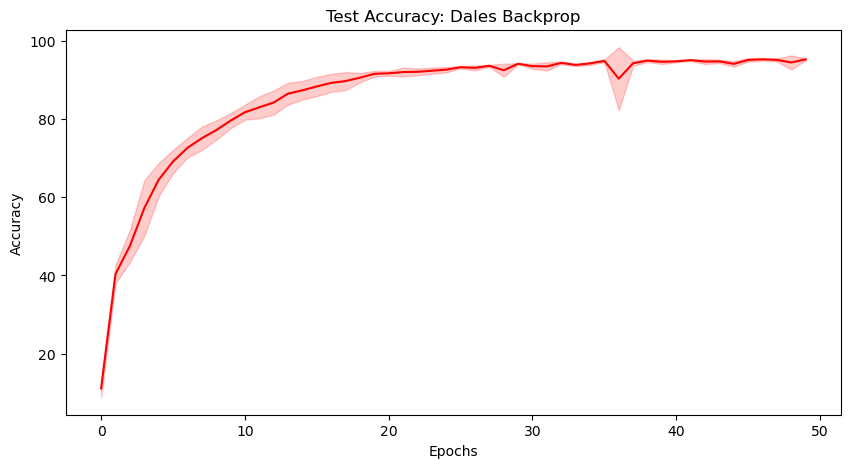

In [31]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=mean_accs, color='r')
plt.fill_between(x, mean_accs - np.sqrt(variance_accs), mean_accs + np.sqrt(variance_accs),
                 color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy: Dales Backprop')

# Show plot
plt.show()